<a href="https://colab.research.google.com/github/jmaroszek/brain_tumors/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup
## Imports

In [ ]:
from google.colab import drive
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from IPython.display import Image as IPImage, display
import pickle

## Directory Structure

In [ ]:
drive.mount('/content/drive')
root_directory = '/content/drive/MyDrive/School/Summer 2024/Practicum/Custom Models'

Mounted at /content/drive


# Training
## Data Preprocessing

In [ ]:
data_path = os.path.join(root_directory, 'Data')
train_path = os.path.join(data_path, 'Training')
test_path = os.path.join(data_path, 'Testing')

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_aug.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## Initialize Model

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

model= Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

83683744/83683744 [==============================] - 1s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          589856    
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                        

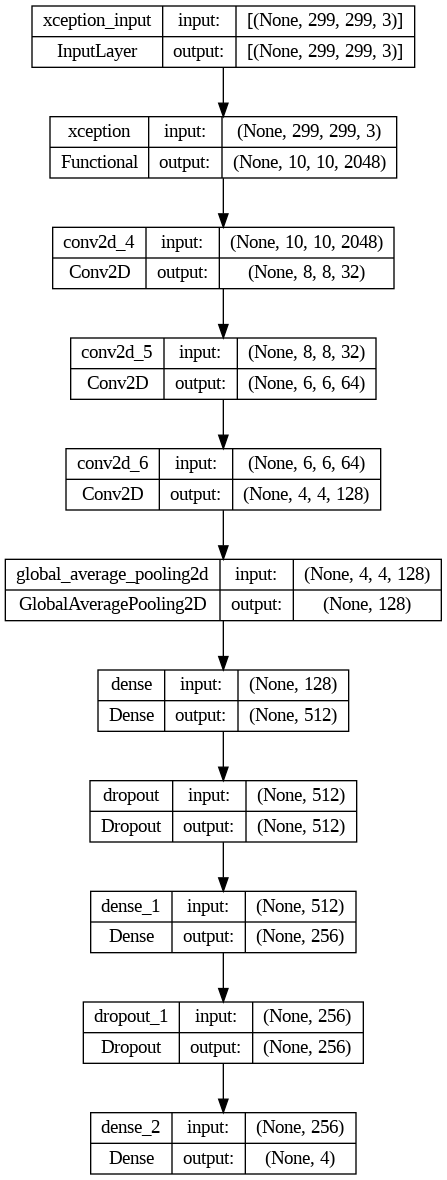

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Run Training

In [ ]:
#directories
xception_path = os.path.join(root_directory, 'Xception')
model_save_path = os.path.join(xception_path, 'xception.keras')
history_path = os.path.join(xception_path, 'xception.pkl')

if not os.path.exists('xception.keras'): #train

  #set up checkpoints
  early_stopping = EarlyStopping(monitor='val_loss',
                                patience=10,
                                restore_best_weights=True)

  adaptive_lr = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=5,
      min_lr=1e-6
  )

  checkpoints = [early_stopping, adaptive_lr]

  #train model
  history = model.fit(
      train_gen,
      epochs=100,
      validation_data=test_gen,
      callbacks=checkpoints
  )

  #save results
  with open(history_path, 'wb') as f:
      pickle.dump(history.history, f)
  print('history saved after training.')

  model.save(model_save_path)
  print('model saved after training.')

else:
  model = tf.keras.models.load_model(model_save_path)
  print('saved model loaded.')

  with open(history_path, 'rb') as f:
      history = pickle.load(f)
  print('saved history loaded.')

Epoch 1/100
179/179 [==============================] - 1897s 10s/step - loss: 0.6099 - accuracy: 0.7696 - precision: 0.8440 - recall: 0.6800 - val_loss: 0.3851 - val_accuracy: 0.8566 - val_precision: 0.8728 - val_recall: 0.8429 - lr: 1.0000e-04
Epoch 2/100
179/179 [==============================] - 168s 938ms/step - loss: 0.3529 - accuracy: 0.8734 - precision: 0.8905 - recall: 0.8601 - val_loss: 0.3222 - val_accuracy: 0.8825 - val_precision: 0.8937 - val_recall: 0.8719 - lr: 1.0000e-04
Epoch 3/100
179/179 [==============================] - 166s 925ms/step - loss: 0.2966 - accuracy: 0.8951 - precision: 0.9061 - recall: 0.8838 - val_loss: 0.3896 - val_accuracy: 0.8642 - val_precision: 0.8733 - val_recall: 0.8574 - lr: 1.0000e-04
Epoch 4/100
179/179 [==============================] - 168s 939ms/step - loss: 0.2674 - accuracy: 0.9070 - precision: 0.9158 - recall: 0.8983 - val_loss: 0.2684 - val_accuracy: 0.9100 - val_precision: 0.9146 - val_recall: 0.9069 - lr: 1.0000e-04
Epoch 5/100
179/1

# Assess Model

In [ ]:
xception_pred_path = os.path.join(xception_path, 'predictions.npy')
if os.path.exists(xception_pred_path):
  xception_preds = np.load(xception_pred_path)
else:
  xception_preds = model.predict(test_gen)
  np.save(xception_pred_path, xception_preds)

y_pred = np.argmax(xception_preds, axis=1)
y_true = test_gen.classes

In [ ]:
classes = sorted(os.listdir(train_path))
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.98      0.95      0.96       300
  meningioma       0.95      0.96      0.95       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



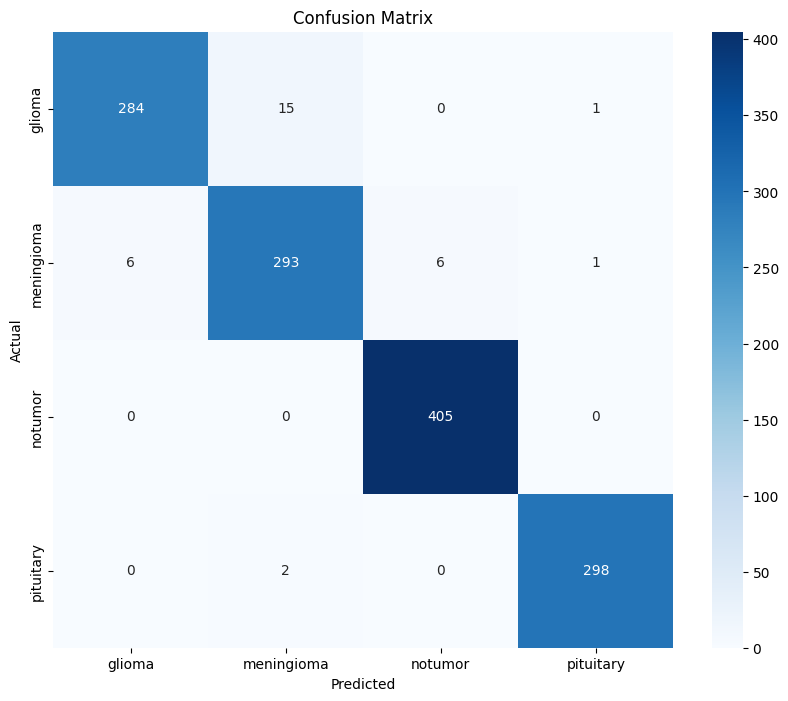

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

conf_plot_path = os.path.join(xception_path, 'confusion_matrix.png')
if not os.path.exists(conf_plot_path):
  plt.savefig(conf_plot_path)

plt.show()

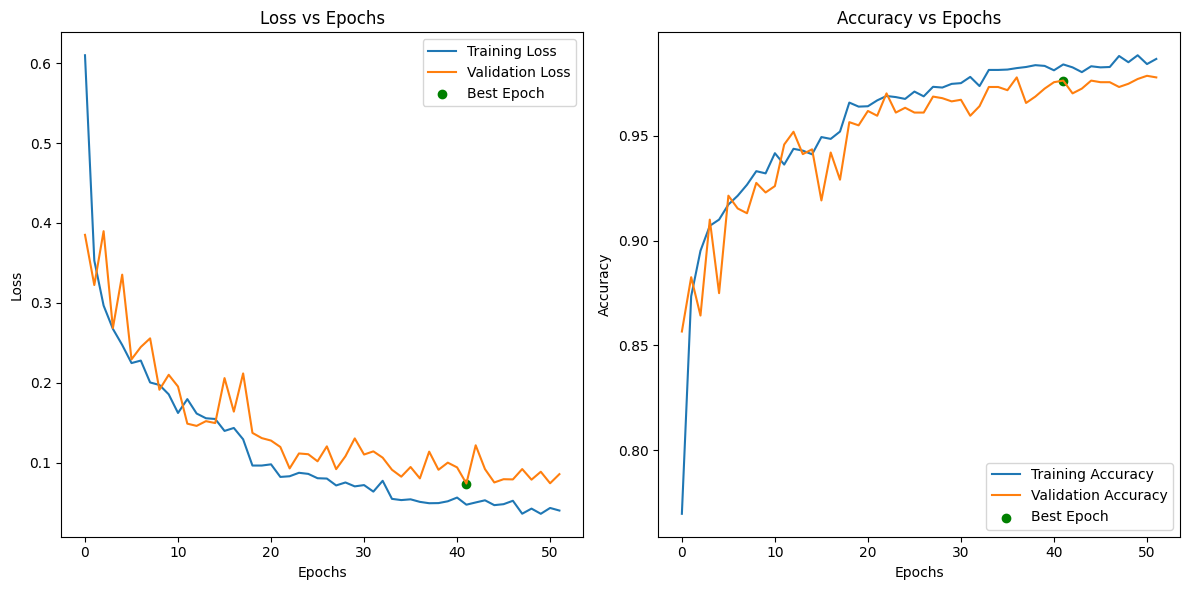

In [ ]:
history_dict = history.history
best_epoch = history_dict['val_loss'].index(min(history_dict['val_loss']))

# Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.scatter(best_epoch, history_dict['val_loss'][best_epoch], color='green', label='Best Epoch')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.scatter(best_epoch, history_dict['val_accuracy'][best_epoch], color='green', label='Best Epoch')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
epoch_plots_path = os.path.join(xception_path, 'epoch_plots.png')
if not os.path.exists(epoch_plots_path):
  plt.savefig(epoch_plots_path)
plt.show()